In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import time
import itertools

In [2]:
# The below code loads the json data from the profiling runs and creates a dataframe with the data 
# The function applies to any file, but the entries below this file are specific to the cifar10 profiling runs and the names of the files

def load_json_data(filename): 
    with open(filename) as f:
        data = json.load(f)

    dataframe =  pd.DataFrame(columns=['batch_size', 'power_limit', 'time_per_epoch', 'average_power'])

    for k, val in data.items():
        for v in val:
            dataframe = dataframe.append({'batch_size' : int(k), 'power_limit': v['power_limit'], 'time_per_epoch': v['time'], 'average_power': v['energy'] / v['time']}, ignore_index=True)

    return dataframe

In [3]:
# Create entries in a df with the key (batch_size) as a column with the other values in the columns
cifar_g3s = load_json_data('trace/trace_cifar_g3s.json')
cifar_g4dn = load_json_data('trace/trace_cifar_g4dn.json')

C:\Users\samde\AppData\Local\Temp\ipykernel_23864\1620928592.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe = dataframe.append({'batch_size' : int(k), 'power_limit': v['power_limit'], 'time_per_epoch': v['time'], 'average_power': v['energy'] / v['time']}, ignore_index=True)
C:\Users\samde\AppData\Local\Temp\ipykernel_23864\1620928592.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe = dataframe.append({'batch_size' : int(k), 'power_limit': v['power_limit'], 'time_per_epoch': v['time'], 'average_power': v['energy'] / v['time']}, ignore_index=True)
C:\Users\samde\AppData\Local\Temp\ipykernel_23864\1620928592.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe = dataframe.append({'batch_

In [5]:
# The below code plots batch size vs average power and batch size vs time per epoch for the dataframe that is passed to it
# This only creates the graph and is not responsible for any curve fitting

def plotBatches(df):
    # Plot the batch size vs average power in a set of graphs for the 4 above subsets
    #color each dot according to its power_limit value
    sns.set_style("whitegrid")
    sns.set_palette("bright")
    sns.set_context("paper")
    sns.set(font_scale=0.8)
    sns.set_style("ticks")

    fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
    fig.suptitle('Average power vs batch size for cifar100, shufflenetv2, adadelta')
    axs[0, 0].scatter(df['batch_size'], df['average_power'], c=df['power_limit'], label= 'HCE')
    axs[0, 0].set_title('A40')
    axs[0, 1].scatter(df['batch_size'], df['average_power'], c=df['power_limit'])
    axs[0, 1].set_title('P100')
    axs[1, 0].scatter(df['batch_size'], df['average_power'], c=df['power_limit'])
    axs[1, 0].set_title('V100')
    axs[1, 1].scatter(df['batch_size'], df['average_power'], c=df['power_limit'])
    axs[1, 1].set_title('RTX6000')

    for ax in axs.flat:
        ax.set(xlabel='batch size', ylabel='average power')

    # PLot legend
    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')

    plt.show()

        #plot time per epoch vs batch size for the same subsets
    sns.set_style("whitegrid")
    sns.set_palette("bright")
    sns.set_context("paper")
    sns.set(font_scale=0.8)
    sns.set_style("ticks")

    fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
    fig.suptitle('Time per epoch vs batch size for cifar100, shufflenetv2, adadelta')
    axs[0, 0].scatter(df['batch_size'], df['time_per_epoch'], c=df['power_limit'])
    axs[0, 0].set_title('A40')
    axs[0, 1].scatter(df['batch_size'], df['time_per_epoch'], c=df['power_limit'])
    axs[0, 1].set_title('P100')
    axs[1, 0].scatter(df['batch_size'], df['time_per_epoch'], c=df['power_limit'])
    axs[1, 0].set_title('V100')
    axs[1, 1].scatter(df['batch_size'], df['time_per_epoch'], c=df['power_limit'])
    axs[1, 1].set_title('RTX6000')

    plt.show()

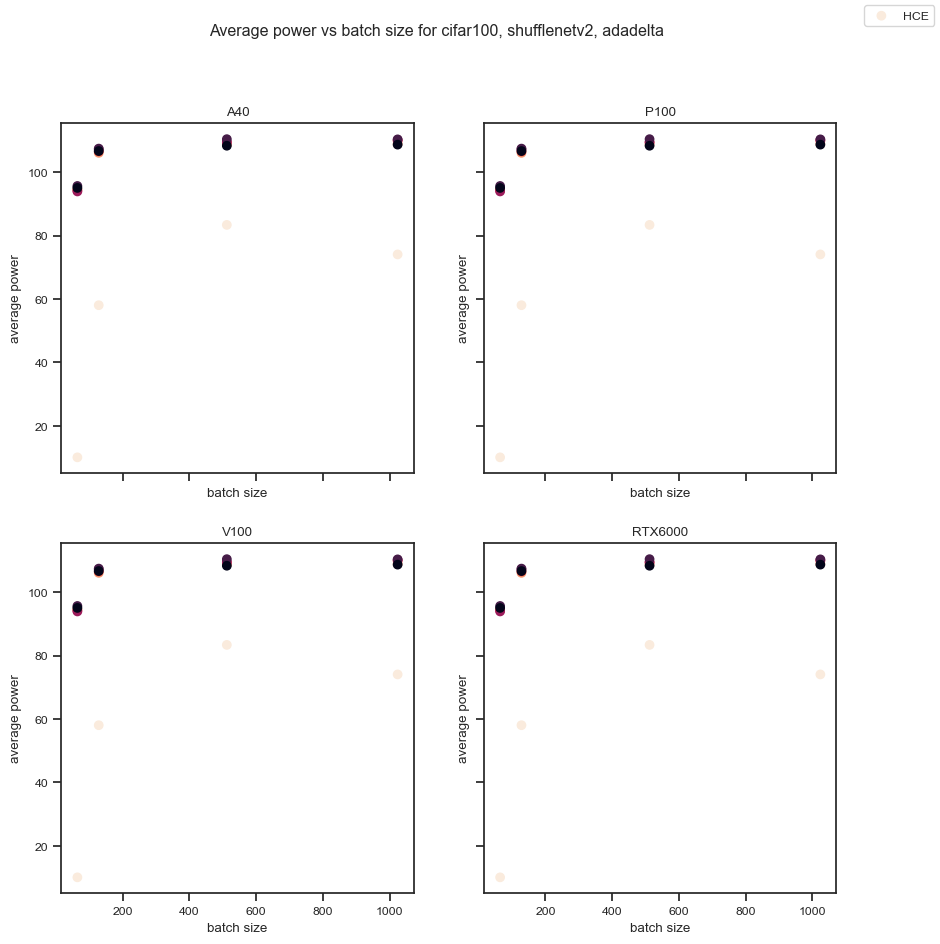

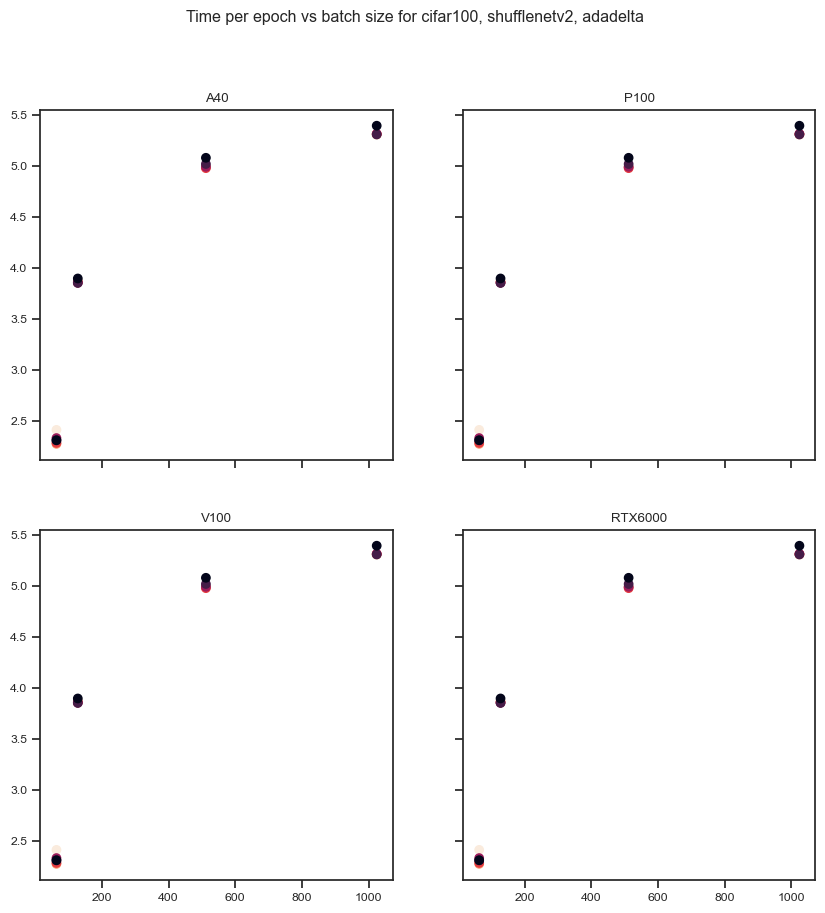

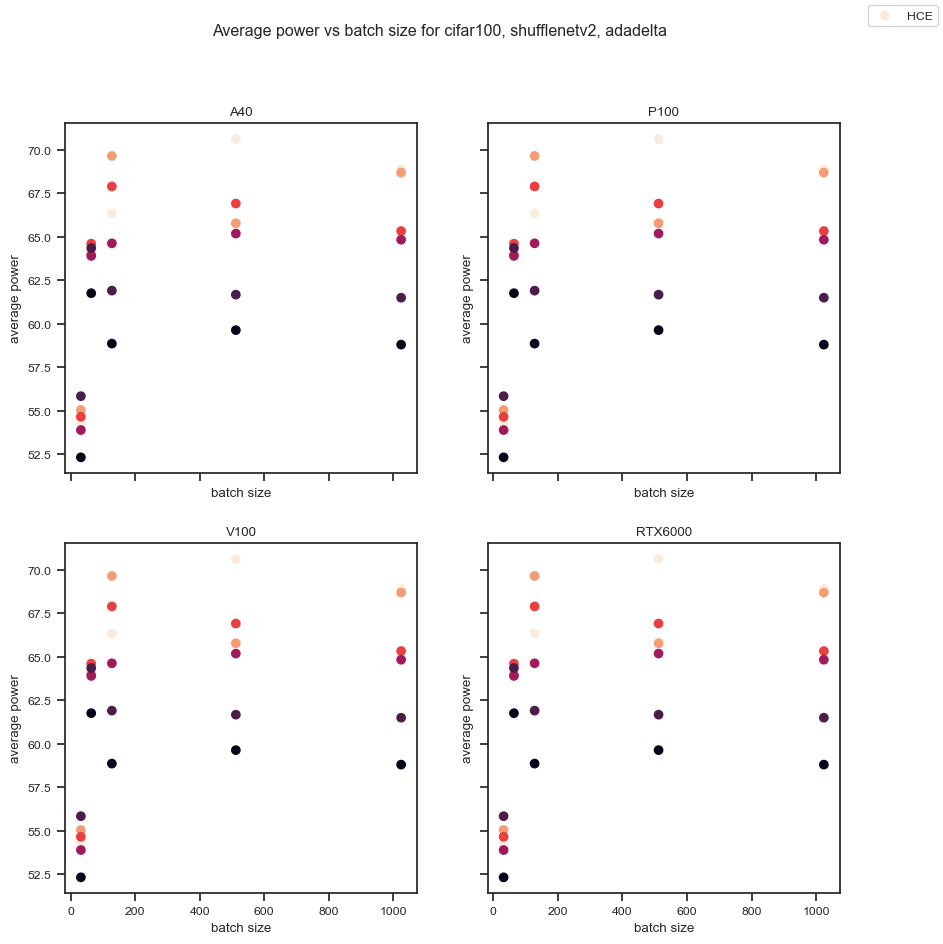

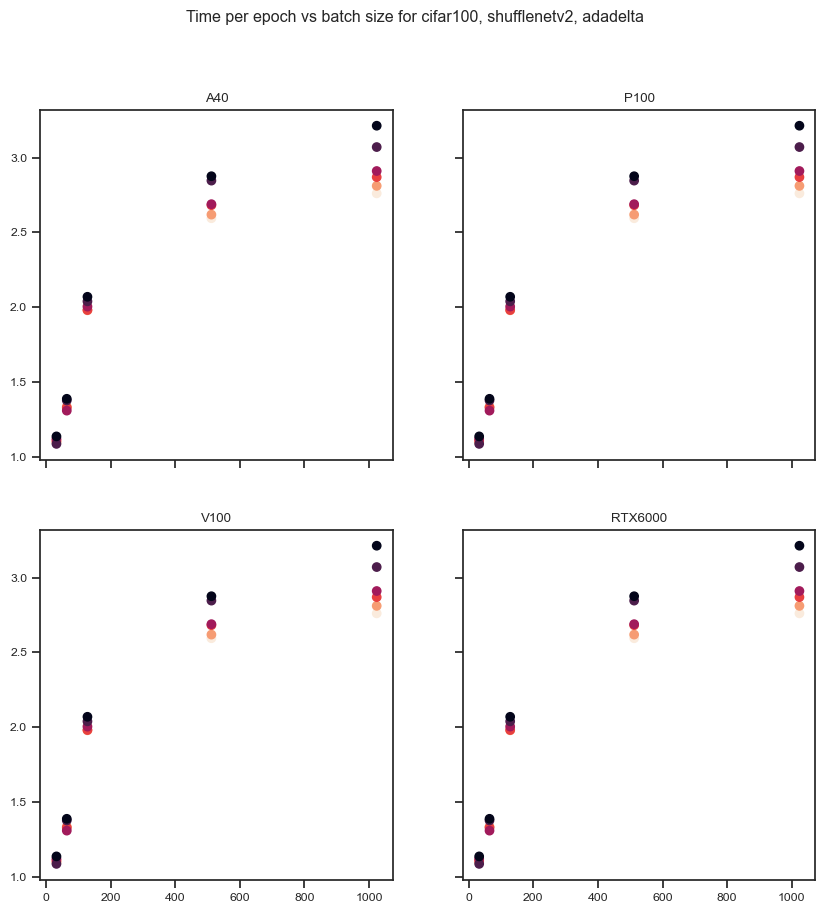

In [6]:
# Plot the batches for the two dataframes that were created
plotBatches(cifar_g3s)
plotBatches(cifar_g4dn)

In [7]:
# The below code fits a curve to the data and plots the curve on the same graph as the data
# The function takes in a dataframe and a string that is the name of the gpu that the data is from
# The function returns two dataframes with the fitted parameters for the time per epoch and average power equations
# The function also plots the data and the fitted curve on the same graph

def fitcurveFunc(df, gpu):
    
    # One color per power limit
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    time_per_epoch_df = []
    

    power_limits = df['power_limit'].unique()

    # Loop through each power limit and create a curve for each:
    for i, p in enumerate(power_limits):

        x_values = df[df['power_limit'] == p]['batch_size'].values
        y_values = df[df['power_limit'] == p]['time_per_epoch'].values
        # Sort the values but keep the points together
        x_values, y_values = zip(*sorted(zip(x_values, y_values)))
        x_values = np.array(x_values)
        y_values = np.array(y_values)

        # Define the function to fit (sum of exponentials)
        def func(x, c,  d, e):
            return   c * x**2 + d * x + e

        # Make a guess for the parameters
        # guess = (1, -.05,  100, 20)
        # Fit the function to the data
        params, covariance = curve_fit(func, x_values, y_values, maxfev=100000)

        # Generate y values for the fitted curve
        y_fit = func(x_values, *params)

        time_per_epoch_df.append(params)

        # Plot the original points and the fitted curve on the same graph
        # Vary the color depending on the power limit
        plt.scatter(x_values, y_values, color = colors[i], label = "p_lim =" + str(p))
        plt.plot(x_values, y_fit, color=colors[i])
        plt.title('TimePerEpoch vs batch size power limit, ' + gpu)
        plt.xlabel('x')
        plt.ylabel('y')
        # Plot the legend in the uppr right corner
        plt.legend(loc='upper right')

        # Print the parameters of the fitted function
        print('Fitted Parameters:', params)
    plt.show()

    avg_power_df = []

    # Loop through each power limit and create a curve for each:
    for i, p in enumerate(power_limits):

        x_values = df[df['power_limit'] == p]['batch_size'].values
        y_values = df[df['power_limit'] == p]['average_power'].values
        # Sort the values but keep the points together
        x_values, y_values = zip(*sorted(zip(x_values, y_values)))
        x_values = np.array(x_values)
        y_values = np.array(y_values)

        # Define the function to fit (sum of exponentials)
        def func(x, a, b, c,  d):
            return a * np.exp(b * x + c) + d

        # Make a guess for the parameters
        guess = (-1, -.05,  100, 20)
        # Fit the function to the data
        params, covariance = curve_fit(func, x_values, y_values, guess, maxfev=100000)

        # Generate y values for the fitted curve
        y_fit = func(x_values, *params)

        avg_power_df.append(params)

        # Plot the original points and the fitted curve on the same graph
        # Vary the color depending on the power limit
        plt.scatter(x_values, y_values, color = colors[i], label = "p_lim =" + str(p))
        plt.plot(x_values, y_fit, color=colors[i])
        plt.title('Average power vs batch size power limit, ' + gpu)
        plt.xlabel('x')
        plt.ylabel('y')
        # Plot the legend in the uppr right corner
        plt.legend(loc='upper right')

            # Print the parameters of the fitted function
        print('Fitted Parameters:', params)
    plt.show()

    return time_per_epoch_df, avg_power_df

Fitted Parameters: [-2.92842271e-06  4.56668124e-03  1.13243781e+00]
Fitted Parameters: [-2.92537004e-06  4.62818841e-03  1.11770445e+00]
Fitted Parameters: [-3.05372571e-06  4.82800830e-03  1.10711158e+00]
Fitted Parameters: [-3.00882581e-06  4.81698469e-03  1.11160655e+00]
Fitted Parameters: [-3.33836049e-06  5.32309935e-03  1.09857695e+00]
Fitted Parameters: [-3.09941413e-06  5.17901800e-03  1.13846680e+00]


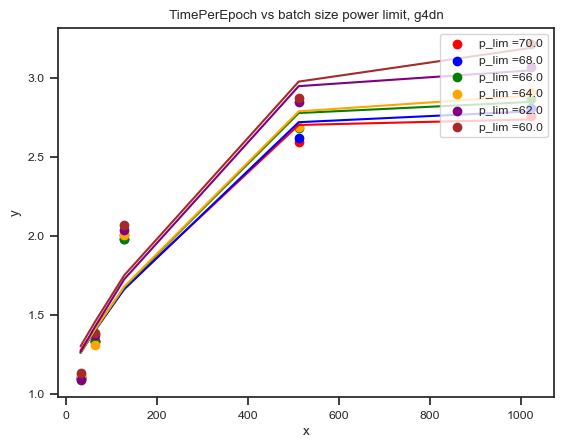

Fitted Parameters: [-3.08478793e-20 -2.78112527e-02  4.84968154e+01  6.91837882e+01]
Fitted Parameters: [-8.79740226e-16 -4.03787022e-02  3.85276060e+01  6.80211722e+01]
Fitted Parameters: [-2.38140096e-17 -5.62734649e-02  4.25666888e+01  6.67092870e+01]
Fitted Parameters: [-3.15060894e-17 -7.52212146e-02  4.28008231e+01  6.48949193e+01]
Fitted Parameters: [-6.86209720e-19 -4.55577695e-01  5.82763749e+01  6.23671139e+01]
Fitted Parameters: [-5.69134854e-17 -4.55047043e-01  5.39736177e+01  5.97729969e+01]


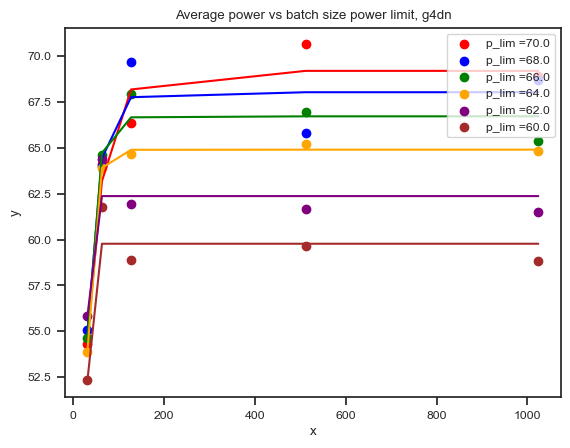

Fitted Parameters: [-4.95839896e-06  7.90707834e-03  2.37921703e+00]
Fitted Parameters: [-5.22857678e-06  8.29510649e-03  2.26728305e+00]
Fitted Parameters: [-5.16978148e-06  8.23209071e-03  2.27270367e+00]
Fitted Parameters: [-5.12687047e-06  8.15915553e-03  2.30627222e+00]
Fitted Parameters: [-5.30890766e-06  8.37102602e-03  2.27373684e+00]
Fitted Parameters: [-5.38382912e-06  8.52353064e-03  2.28092053e+00]


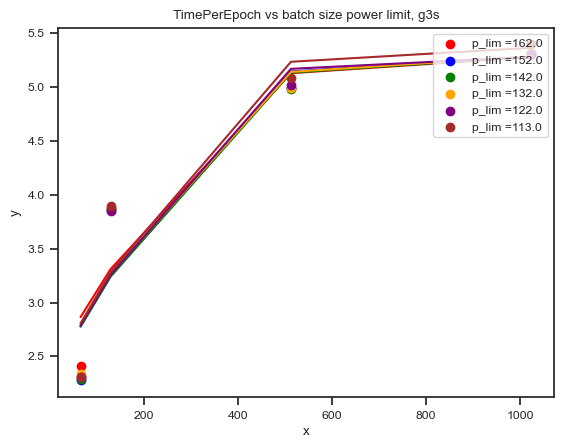

C:\Users\samde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Fitted Parameters: [-3.76093313e-07 -4.99999363e-02  2.26542896e+01  8.39177448e+01]
Fitted Parameters: [-2.03508164e-07 -2.61289274e-02  1.97281595e+01  1.08770982e+02]
Fitted Parameters: [-1.47417007e-22 -2.51625554e-02  5.46111821e+01  1.09640850e+02]
Fitted Parameters: [-6.17407084e-14 -2.83807163e-02  3.49990193e+01  1.09858122e+02]
Fitted Parameters: [-4.14592821e-22 -2.51571203e-02  5.35349391e+01  1.10406842e+02]
Fitted Parameters: [-1.95328547e-19 -6.52604921e-02  4.95554887e+01  1.07237679e+02]


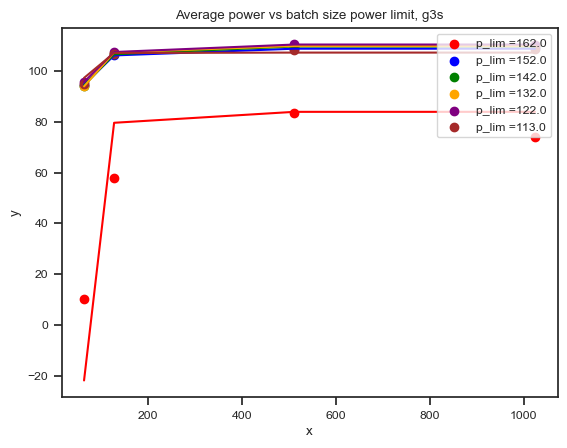

In [8]:
# Fit the curves for the two dataframes
time_per_epoch_g4dn, avg_power_g4dn = fitcurveFunc(cifar_g4dn, 'g4dn')
time_per_epoch_g3s, avg_power_g3s = fitcurveFunc(cifar_g3s, 'g3s')

In [9]:
# The below code finds the optimal allocaton of global batch size 4096 between the two GPUs
# The function takes in:
# - The fitted parameters for the time per epoch and average power equations for both GPUs
# - The power limits for both GPUs
# - The GPU strengths for both GPUs-- we assume that the lower ranked gpu (ie 1 as opposed to 2) is the stronger GPU
# - A boolean that is true if we want to find the optimal allocation for the naive version of the algorithm or false if we use the heuristic of allocatin weakest power limit to the strongest GPU
# The function returns a dictionary with the optimal allocation and the time it took to run the function

def findOptimalAllocation(power_limits_df1, power_limits_df2, gpuStrengths, naiveVersion, time_per_epoch_df1, time_per_epoch_df2, avg_power_df1, avg_power_df2):
    # Start time 
    start_time = time.time()
    # Generate batch sizes from the above equations:
    batchsizes = range(0, 4096, 1)
    
    batch_and_power_df1 = []
    batch_and_power_df2= []

    # Find the index of the in GPU strengths:
    maxGPU = gpuStrengths.index(min(gpuStrengths))

    def fillBatchAndPower(gpuType, isMaximum, naiveVersion):
        if gpuType == 0:
            if not naiveVersion and isMaximum:
                minPower = min(power_limits_df1)
                for b in batchsizes:
                    batch_and_power_df1.append((b, list(power_limits_df1).index(minPower)))
            else:
                for b in batchsizes:
                    for i in range(len(power_limits_df1)):
                        batch_and_power_df1.append((b, i))
        elif gpuType == 1:
            if not naiveVersion and isMaximum:
                minPower = min(power_limits_df2)
                for b in batchsizes:
                    batch_and_power_df2.append((b, list(power_limits_df2).index(minPower)))
            else:
                for b in batchsizes:
                    for i in range(len(power_limits_df2)):
                        batch_and_power_df2.append((b, i))
    
    fillBatchAndPower(0, 0 == maxGPU, naiveVersion)
    fillBatchAndPower(1, 1 == maxGPU, naiveVersion)

    print(batch_and_power_df1)
    results5 = {}
    global_batch_size = 4096
    for b1, p1 in batch_and_power_df1:
        for b2, p2 in batch_and_power_df2:
            b = [b1, b2]
            if sum(b) == global_batch_size:
                result = 0
                for i, batch in enumerate(b):
                    if i % 4 == 0:
                        time_per_epoch = time_per_epoch_df1[p1][0] * batch**2 + time_per_epoch_df1[p1][1] * batch + time_per_epoch_df1[p1][2]
                        if time_per_epoch < 0:
                            time_per_epoch = 0 
                        average_power = avg_power_df1[p1][0] * np.exp(avg_power_df1[p1][1] * batch + avg_power_df1[p1][2]) + avg_power_df1[p1][3]
                        if average_power < 0:
                            average_power = 0
                        
                        power_limit = power_limits_df1[p1]
                    elif i % 4 == 1:
                        time_per_epoch = time_per_epoch_df2[p2][0] * batch**2 + time_per_epoch_df2[p2][1] * batch + time_per_epoch_df2[p2][2]
                        if time_per_epoch < 0:
                            time_per_epoch = 0
                        average_power = avg_power_df2[p2][0] * np.exp(avg_power_df2[p2][1] * batch + avg_power_df2[p2][2]) + avg_power_df2[p2][3]
                        if average_power < 0:
                            average_power = 0
                        power_limit = power_limits_df2[p2]
                    # Calculate the results:
                    result += (.5 * average_power + .5 * power_limit) * time_per_epoch
                powerlimit1 = power_limits_df1[p1]
                powerlimit2 = power_limits_df2[p2]
                results5[tuple([(b1, powerlimit1), (b2, powerlimit2)])] = result
    # Stop the time 
    end_time = time.time()
    return results5, end_time - start_time

In [10]:
# The below code runs the simulation for all combinations of the GPUs
# The function takes in:
# - The names of the GPUs
# - The power limits for both GPUs
# - The fitted parameters for the time per epoch and average power equations for both GPUs
# - The GPU strengths for both GPUs-- we assume that the lower ranked gpu (ie 1 as opposed to 2) is the stronger GPU
# The function returns a dataframe with the results of the simulation

def runSimulation(gpuNames, gpuPowerLimits, avg_power_dfs, time_per_epoch_dfs, gpuStrengths):
    finalResults = pd.DataFrame(columns=['gpu1', 'gpu2', 'time', 'naive', 'cost', 'topAllocation', 'maxCost'])
    # Get all combinations of the GPUs
    for i1, i2 in itertools.combinations(range(len(gpuNames)), 2):
        gpuStrength = [gpuStrengths[i1], gpuStrengths[i2]]
        # Get the gpu names
        gpu1 = gpuNames[i1]
        gpu2 = gpuNames[i2]
        # Get the time per epoch and average power for each of the GPUs
        time_per_epoch_df1 = time_per_epoch_dfs[i1]
        time_per_epoch_df2 = time_per_epoch_dfs[i2]

        avg_power_df1 = avg_power_dfs[i1]
        avg_power_df2 = avg_power_dfs[i2]

        power_limits_df1 = gpuPowerLimits[i1]
        power_limits_df2 = gpuPowerLimits[i2]

        # Run the simulation for the naive and non naive versions
        results5, time_taken = findOptimalAllocation(power_limits_df1, power_limits_df2, gpuStrength, True, time_per_epoch_df1, time_per_epoch_df2, avg_power_df1, avg_power_df2)
        finalResults = finalResults.append({'gpu1': gpu1, 'gpu2': gpu2, 'time': time_taken, 'naive': True, 'cost': min(results5.values()), 'topAllocation': sorted(results5.items(), key=lambda item: item[1])[0], 'maxCost': max(results5.values())}, ignore_index=True)
        results5, time_taken = findOptimalAllocation(power_limits_df1, power_limits_df2, gpuStrength, False, time_per_epoch_df1, time_per_epoch_df2, avg_power_df1, avg_power_df2)
        finalResults = finalResults.append({'gpu1': gpu1, 'gpu2': gpu2, 'time': time_taken, 'naive': False, 'cost': min(results5.values()), 'topAllocation': sorted(results5.items(), key=lambda item: item[1])[0], 'maxCost': max(results5.values())}, ignore_index=True)

        print("Iteration completed")
    return finalResults

In [12]:
# Run the simulation for the two given GPUs
gpuNames = ['g4dn', 'g3s']
gpuPowerLimits = [cifar_g4dn["power_limit"].unique(), cifar_g3s["power_limit"].unique()]
avg_power_dfs = [avg_power_g4dn, avg_power_g3s]
time_per_epoch_dfs = [time_per_epoch_g3s, time_per_epoch_g4dn]
gpuStrengths = [2,1]
finalResults = runSimulation(gpuNames, gpuPowerLimits, avg_power_dfs, time_per_epoch_dfs, gpuStrengths)

# Save the results to a csv file
finalResults.to_csv('g4dn_g3s_results_2.csv')
finalResults

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (10, 0), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (11, 0), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (12, 0), (12, 1), (12, 2), (12, 3), (12, 4), (12, 5), (13, 0), (13, 1), (13, 2), (13, 3), (13, 4), (13, 5), (14, 0), (14, 1), (14, 2), (14, 3), (14, 4), (14, 5), (15, 0), (15, 1), (15, 2), (15, 3), (15, 4), (15, 5), (16, 0), (16, 1), (16, 2), (16, 3), (16, 4), (16, 5), (17, 0), (17, 1), (17, 2), (17, 3), (17, 4), (17, 5), (18, 0), (18, 1), (18, 2), (18, 3), (18, 4), (18, 5), (19, 0), (19, 1), (19, 2), (19, 3

C:\Users\samde\AppData\Local\Temp\ipykernel_23864\110364721.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  finalResults = finalResults.append({'gpu1': gpu1, 'gpu2': gpu2, 'time': time_taken, 'naive': True, 'cost': min(results5.values()), 'topAllocation': sorted(results5.items(), key=lambda item: item[1])[0], 'maxCost': max(results5.values())}, ignore_index=True)


[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (10, 0), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (11, 0), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (12, 0), (12, 1), (12, 2), (12, 3), (12, 4), (12, 5), (13, 0), (13, 1), (13, 2), (13, 3), (13, 4), (13, 5), (14, 0), (14, 1), (14, 2), (14, 3), (14, 4), (14, 5), (15, 0), (15, 1), (15, 2), (15, 3), (15, 4), (15, 5), (16, 0), (16, 1), (16, 2), (16, 3), (16, 4), (16, 5), (17, 0), (17, 1), (17, 2), (17, 3), (17, 4), (17, 5), (18, 0), (18, 1), (18, 2), (18, 3), (18, 4), (18, 5), (19, 0), (19, 1), (19, 2), (19, 3

C:\Users\samde\AppData\Local\Temp\ipykernel_23864\110364721.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  finalResults = finalResults.append({'gpu1': gpu1, 'gpu2': gpu2, 'time': time_taken, 'naive': False, 'cost': min(results5.values()), 'topAllocation': sorted(results5.items(), key=lambda item: item[1])[0], 'maxCost': max(results5.values())}, ignore_index=True)
C:\Users\samde\AppData\Local\Temp\ipykernel_23864\110364721.py:31: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  finalResults = finalResults.append({'gpu1': gpu1, 'gpu2': gpu2, 'time': time_taken, 'naive': False, 'cost': min(results5.values()), 'topAllocation': sorted(results5.items(), key=lambda item: item[1])[0], 'maxCost': max(results5.values())}, ignore_index=True)


,gpu1,gpu2,time,naive,cost,topAllocation,maxCost
0,g4dn,g3s,127.232490,True,0.0,"(((1814, 62.0), (2282, 162.0)), 0.0)",384.950263
1,g4dn,g3s,23.044295,False,0.0,"(((1814, 62.0), (2282, 113.0)), 0.0)",384.950263


In [17]:
# The below code calculates the baseline results for the two GPUs where we assume that the batches are split evenly between the GPUs
# The function takes in:
# - The names of the GPUs
# - The power limits for both GPUs
# - The fitted parameters for the time per epoch and average power equations for both GPUs
# - The GPU strengths for both GPUs-- we assume that the lower ranked gpu (ie 1 as opposed to 2) is the stronger GPU
# The function returns a dataframe with the results of the simulation
def calculateBaseline(gpuNames, gpuPowerLimits, avg_power_dfs, time_per_epoch_dfs, gpuStrengths):
    baselineResults = pd.DataFrame(columns=['gpu1', 'gpu2', 'time', 'naive', 'cost', 'top20List'])
    global_batch_size = 4096
    # Get the baseline results for each of the GPUs if batches were split evenly between the GPUs
    for i1, i2 in itertools.combinations(range(len(gpuNames)), 2):
        # Get the gpu names
        gpu1 = gpuNames[i1]
        gpu2 = gpuNames[i2]
        # Get the time per epoch and average power for each of the GPUs
        time_per_epoch_df1 = time_per_epoch_dfs[i1]
        time_per_epoch_df2 = time_per_epoch_dfs[i2]

        avg_power_df1 = avg_power_dfs[i1]
        avg_power_df2 = avg_power_dfs[i2]

        power_limits_df1 = gpuPowerLimits[i1]
        power_limits_df2 = gpuPowerLimits[i2]

        tempResults = {}
        
        for p1 in range(len(power_limits_df1)):
            for p2 in range(len(power_limits_df2)):
                b = [2048, 2048]
                if sum(b) == global_batch_size:
                    result = 0
                    for i, batch in enumerate(b):
                        if i % 4 == 0:
                            time_per_epoch = time_per_epoch_df1[p1][0] * batch**2 + time_per_epoch_df1[p1][1] * batch + time_per_epoch_df1[p1][2]
                            average_power = avg_power_df1[p1][0] * np.exp(avg_power_df1[p1][1] * batch + avg_power_df1[p1][2]) + avg_power_df1[p1][3]
                            power_limit = power_limits_df1[p1]
                        elif i % 4 == 1:
                            time_per_epoch = time_per_epoch_df2[p2][0] * batch**2 + time_per_epoch_df2[p2][1] * batch + time_per_epoch_df2[p2][2]
                            average_power = avg_power_df2[p2][0] * np.exp(avg_power_df2[p2][1] * batch + avg_power_df2[p2][2]) + avg_power_df2[p2][3]
                            power_limit = power_limits_df2[p2]
                        
                    # Calculate the results:
                    result += (.5 * average_power + .5 * power_limit) * time_per_epoch
                powerlimit1 = power_limits_df1[p1]
                powerlimit2 = power_limits_df2[p2]
                tempResults[tuple([(2048, powerlimit1), (2048, powerlimit2)])] = result
    
    baselineResults = baselineResults.append({'gpu1': gpu1, 'gpu2': gpu2, 'time': 0, 'naive': False, 'cost': min(tempResults.values()), 'topAllocation': sorted(tempResults.items(), key=lambda item: item[1])[0]}, ignore_index=True)
    return baselineResults

In [18]:
# Run the baseline for the two given GPUs
gpuNames = ['g4dn', 'g3s']
gpuPowerLimits = [cifar_g4dn["power_limit"].unique(), cifar_g3s["power_limit"].unique()]
avg_power_dfs = [avg_power_g4dn, avg_power_g3s]
time_per_epoch_dfs = [time_per_epoch_g3s, time_per_epoch_g4dn]
gpuStrengths = [2,1]
baselineResults = calculateBaseline(gpuNames, gpuPowerLimits, avg_power_dfs, time_per_epoch_dfs, gpuStrengths)

# Save the results to a csv file
baselineResults.to_csv('g4dn_g3s_baseline.csv')
baselineResults

C:\Users\samde\AppData\Local\Temp\ipykernel_23864\2842563624.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  baselineResults = baselineResults.append({'gpu1': gpu1, 'gpu2': gpu2, 'time': 0, 'naive': False, 'cost': min(tempResults.values()), 'topAllocation': sorted(tempResults.items(), key=lambda item: item[1])[0]}, ignore_index=True)


,gpu1,gpu2,time,naive,cost,top20List,topAllocation
0,g4dn,g3s,0,False,-232.617674,NaN,"(((2048, 70.0), (2048, 122.0)), -232.617673805..."
